# MPC Example Using Scipy optimization
reference: 

https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html

To Do:

Create NL model; create function to simulate response to input; 


In [3]:
import numpy as np
import scipy.signal
import scipy.optimize
import matplotlib.pyplot as plt
from time import time
%matplotlib inline

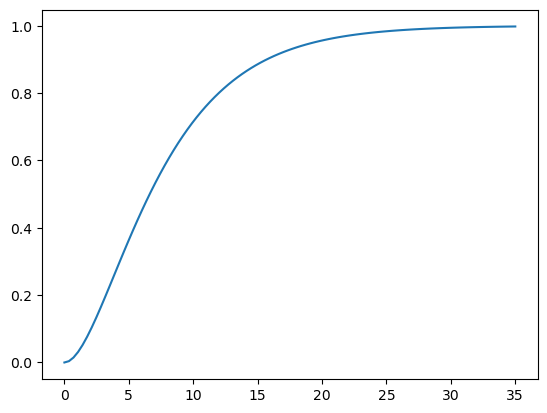

In [2]:
G = scipy.signal.lti([1], [15, 8, 1])
plt.plot(*G.step());

In [31]:
M = 10  # Control horizon
P = 100  # Prediction horizon
DeltaT = .1  # Sampling rate
tcontinuous = np.linspace(0, P*DeltaT, 1000)  # some closely spaced time points
tpredict = np.arange(0, P*DeltaT, DeltaT)   # discrete points at prediction horizon

# first order reference trajectory
tau_c = 1
r = 1 - np.exp(-tpredict/tau_c)  

u = np.ones(M)  # initial guess for optimized control

x0 = np.zeros(G.to_ss().A.shape[0])  # Initial system state

In [5]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

In [6]:
def prediction(u, t=tpredict, x0=x0):
    """Predict the effect of an input signal"""
    t, y, x = scipy.signal.lsim(G, u, t, X0=x0, interp=False)
    return y

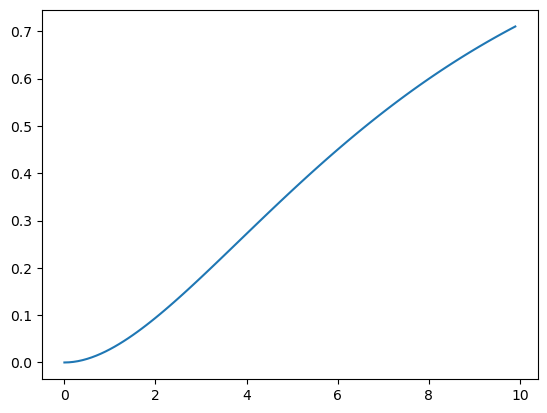

In [7]:
plt.plot(tpredict, prediction(extend(u)));


In [8]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = prediction(extend(u))
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])
    movepenalty = sum(np.abs(np.diff(u)))
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.0*movepenalty + 0*strongfinish

In [9]:
objective(u)

32.94191787624922

In [10]:
result = scipy.optimize.minimize(objective, u)
uopt = result.x
result.fun

0.029481857105720054

In [11]:
ucont = extend(uopt)[((tcontinuous-0.01)//DeltaT).astype(int)]


In [12]:
def plotoutput(ucont, uopt):
    plt.figure()
    plt.plot(tcontinuous, ucont)
    plt.xlim([0, DeltaT*(P+1)])
    plt.grid()
    plt.figure()
    plt.plot(tcontinuous, prediction(ucont, tcontinuous), label='Continuous response')
    plt.plot(tpredict, prediction(extend(uopt)), '-o', label='Optimized response')
    plt.plot(tpredict, r, label='Set point')
    plt.grid()
    plt.legend()

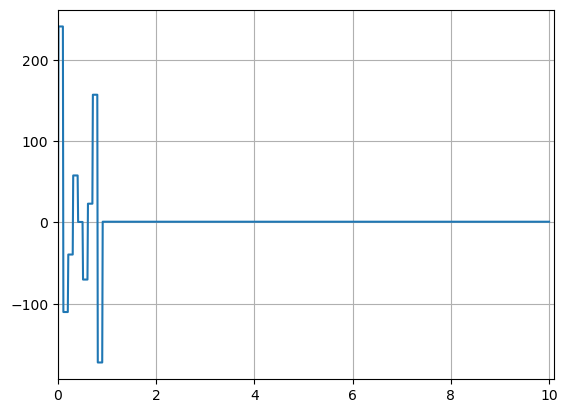

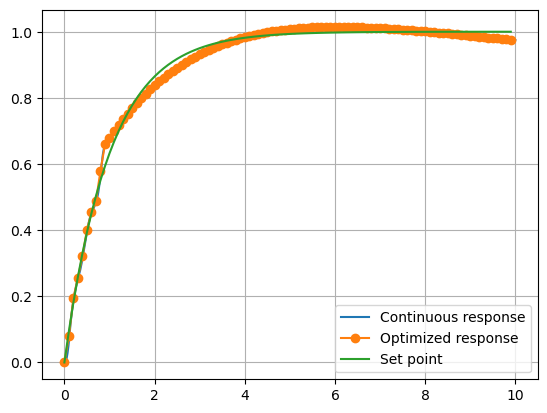

In [13]:
plotoutput(ucont, uopt)

### Simple NL MPC Model

Stable continuous nonlinear model: <br /> 
$\dot{x} = -x^{3} + u$

In discrete time using finite difference: <br /> 
$x[k+1] = x[k] - \Delta T x[k]^{3} + \Delta T u[k]$

Steady state output:  1.2485555011266727


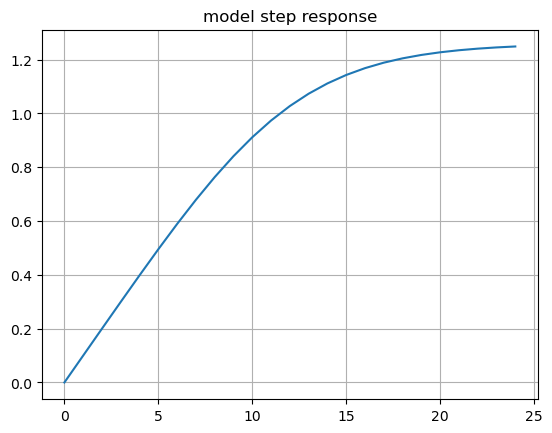

In [142]:
x = np.zeros(25)
u = 2*np.ones(25)
dt = 0.05
for k in range(len(x)-1):
    x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
plt.plot(x)
plt.title("model step response")
plt.grid()
print("Steady state output: ", x[-1])

In [143]:
def nl_prediction(u, dt, x0=x0):
    """Predict the effect of an input signal"""
    x = np.empty(len(u))    
    x[0] = x0
    for k in range(len(x)-1):
        x[k+1] = x[k] -dt*x[k]**3 + dt*u[k]
    
    return x

In [144]:
'''
def objective(u, x0=x0):
    """Calculate the sum of the square error for the cotnrol problem"""
    y = prediction(extend(u))
    return sum((r - y)**2)
'''
def objective(u, x0=x0):
    y = nl_prediction(extend(u), dt, x0)    
    umag = np.abs(u)
    constraintpenalty = sum(umag[umag > 2])    
    #movepenalty = sum(np.abs(np.diff(u)))
    movepenalty = sum(np.diff(u)**2)
    strongfinish = np.abs(y[-1] - r[-1])
    return sum((r - y)**2) + 0.0*constraintpenalty + 0.0*movepenalty + 0*strongfinish

In [145]:
def extend(u):
    """We optimise the first M values of u but we need P values for prediction"""
    return np.concatenate([u, np.repeat(u[-1], P-M)])

In [146]:
# plot results
def plot_results(timeSamples, x, ref, u):    
    plt.figure()
    plt.plot(timeSamples, x, '-bo', label = 'Output')
    plt.plot(timeSamples, ref[:len(timeSamples)], 'r', label='Reference')
    plt.grid()
    plt.legend()    
    plt.figure()
    plt.plot(timeSamples, u, label='Control')
    plt.grid()
    plt.legend()
    plt.figure()
    plt.plot(timeSamples[0:-1], np.diff(u, axis=0), label='\delta Control')
    plt.grid()
    plt.legend()


In [147]:
M = 50
P = 50

# first order reference trajectory
tau_c = 1
tpredict = np.arange(0, P*dt, dt)   # discrete points at prediction horizon
r = 2 - 2*np.exp(-tpredict/tau_c)  
u = np.zeros(M)  # initial guess for optimized control


In [148]:
from scipy.optimize import LinearConstraint
A= -np.eye(M)+np.eye(M, k=1)
lb = -0.75
ub = 0.75
linear_constraint = LinearConstraint(A, lb*np.ones((M,)), ub*np.ones((M,)))

28.367533445358276
0.3699230096252907


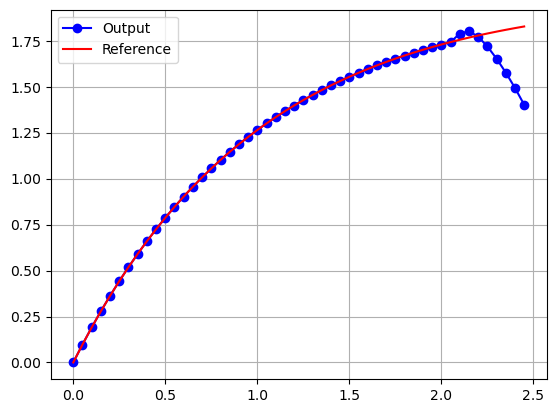

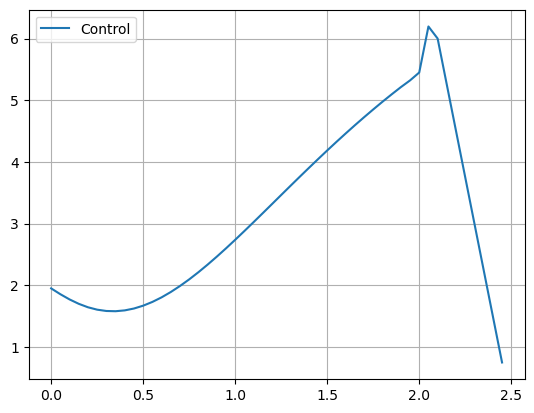

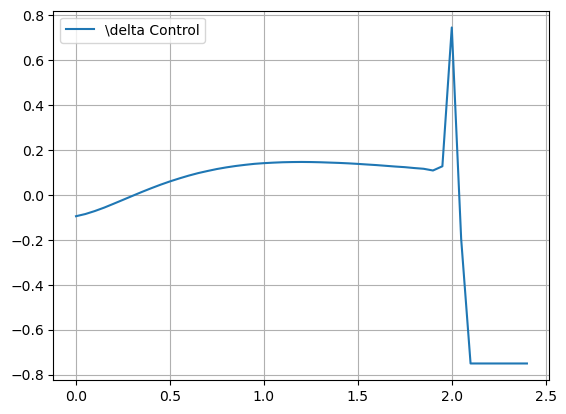

In [150]:
x0 = 0
startTime = time()
result = scipy.optimize.minimize(objective, u, method = 'trust-constr', constraints=[linear_constraint])
#result = scipy.optimize.minimize(objective, u)
print(time()-startTime)
uopt = result.x
print(result.fun)
uact = extend(uopt)
plot_results(tpredict, nl_prediction(uact, dt), r, uact)

## Simulate control loop 

In [151]:
# Set initial conditions and tuning parameters
M = 75
P = 100
simTime = 50
dt = 0.1
cycles = int(simTime/dt)
x = np.zeros((cycles, 1))
uact = np.ones((cycles, 1))

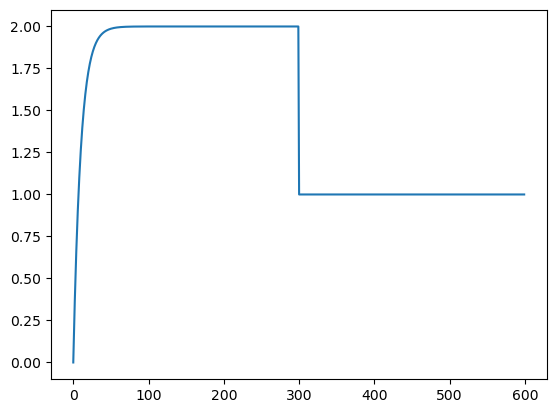

In [152]:
#set reference trajectory
tau_c = 1
t1 = np.arange(0, P*dt, dt)
ref1 = 2 - 2*np.exp(-t1/tau_c)  
ref2 = np.repeat(ref1[-1], 200)
ref3 = np.repeat(1, 300)
ref4 = np.repeat(-1, P+cycles-len(ref1)-len(ref2)-len(ref3))
ref = np.concatenate([ref1, ref2, ref3, ref4])
plt.plot(ref)

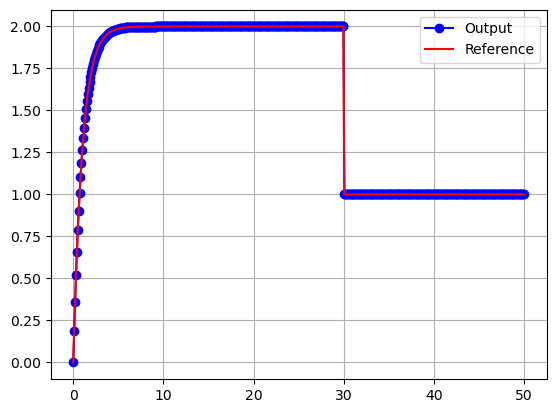

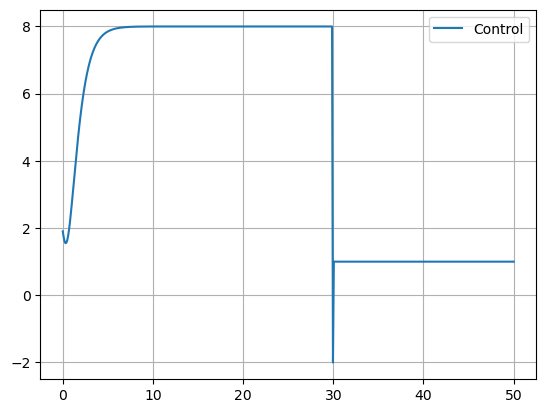

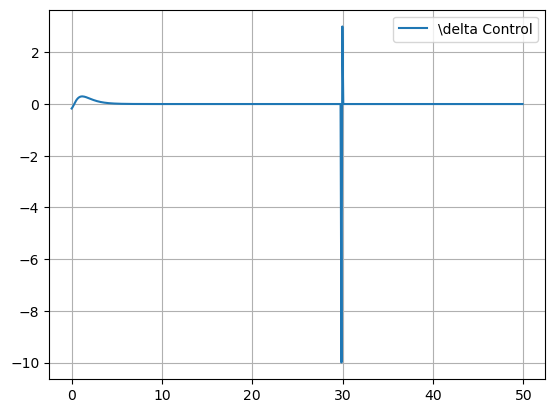

In [153]:
import warnings
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
# simulation loop
u = np.ones(M)  # optimization initial guess
for k in range(cycles-1):
    r = ref[k:k+P]
    x0 = x[k]
    # call optimization    
    result = scipy.optimize.minimize(objective, u, x0)
    #result = scipy.optimize.minimize(objective, u, x0, method = 'trust-constr', constraints=[linear_constraint])
    uopt = result.x    
    uact[k] = uopt[0]
    
    # simulate plant with control input
    x[k+1] = x[k] -dt*x[k]**3 + dt*uact[k]
    
    u = uact[k]*np.ones(M)  # update optimization guess for the next iteration
    
    if np.abs(x[k]) > 1E6:
        break
        
# plot results
timeSamples = np.linspace(0, simTime, len(x))
plot_results(timeSamples, x, ref, uact)